In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import signal,stats
import os
import h5py

In [2]:
from data_augmentation import TransientMaker

In [3]:
###Definition:
path_to_original_data = '../simulated_ground_truths.h5'
random_augment = {'amplitude':{'noise_level_base':{'max':20,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'frequency':{'noise_level_base':{'max':40,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'phase':{'noise_level_base':{'max':40,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}}}
start=4000
stop=5000
name_dataset_to_be_created = '../dataset_test_multiplenoise_from_SGT_4000_to_5000.h5'

In [4]:
def get_interval_method_augment(key,random_augment):
    if key in random_augment.keys():
        max = random_augment[key]["noise_level_base"]["max"] + 1
        min = random_augment[key]["noise_level_base"]["min"]

        noise_level_base = np.random.randint(min, max)

        max = random_augment[key]["noise_level_scan_var"]["max"] + 1
        min = random_augment[key]["noise_level_scan_var"]["min"]

        noise_level_scan_var = np.random.randint(min, max)

        return noise_level_base, noise_level_scan_var
    else:
        return None,None

corrupted_fids = np.empty((stop-start,2048,2,40),dtype='complex128')
gt_fids = np.empty((stop-start,2048,2),dtype='complex128')
ppm_of_corrupted_fids = np.empty((stop-start,2048))
t_of_corrupted_fids = np.empty((stop-start,2048))
target_of_corrupted_fids = np.empty((stop-start,2048),dtype='complex128')
stats_ds_base = [[],[],[]]
stats_ds_var = [[],[],[]]
for i in range(start,stop):
    with h5py.File(path_to_original_data) as hf:
        fid = hf["ground_truth_fids"][()][i:i+1]
        ppm = hf["ppm"][()][i:i+1]
        t = hf["t"][()][i:i+1]

    noise_amplitude_base, noise_amplitude_var = get_interval_method_augment("amplitude",random_augment)
    noise_frequency_base, noise_frequency_var = get_interval_method_augment("frequency",random_augment)
    noise_phase_base, noise_phase_var = get_interval_method_augment("phase",random_augment)
    stats_ds_base[0].append(noise_amplitude_base)
    stats_ds_base[1].append(noise_frequency_base)
    stats_ds_base[2].append(noise_phase_base)
    stats_ds_var[0].append(noise_amplitude_var)
    stats_ds_var[1].append(noise_frequency_var)
    stats_ds_var[2].append(noise_phase_var)

    transientmkr = TransientMaker(fids=fid, t=t, n_transients=40)
    if noise_amplitude_base is not None and noise_amplitude_var is not None:
        transientmkr.add_random_amplitude_noise(noise_level_base=noise_amplitude_base, 
                                                noise_level_scan_var=noise_amplitude_var)
    if noise_frequency_base is not None and noise_frequency_var is not None:
        transientmkr.add_random_frequency_noise(noise_level_base=noise_frequency_base, 
                                                noise_level_scan_var=noise_frequency_var)
    if noise_phase_base is not None and noise_phase_var is not None:
        transientmkr.add_random_phase_noise(noise_level_base=noise_phase_base, 
                                                noise_level_scan_var=noise_phase_var)
    aug_fids = transientmkr.fids
    corrupted_fids[i-start,:,:,:] = aug_fids[0,:,:,:]
    ppm_of_corrupted_fids[i-start,:] = ppm[0,:]
    t_of_corrupted_fids[i-start,:] = t[0,:]
    gt_fids[i-start,:,:] = fid[0,:,:]

    spectra_gt_fid = np.fft.fftshift(np.fft.fft(fid[0, :, :], n=fid.shape[1], axis=0), axes=0)
    spectra_gt_diff = spectra_gt_fid[:, 1] - spectra_gt_fid[:, 0]
    target_of_corrupted_fids[i-start,:] = spectra_gt_diff


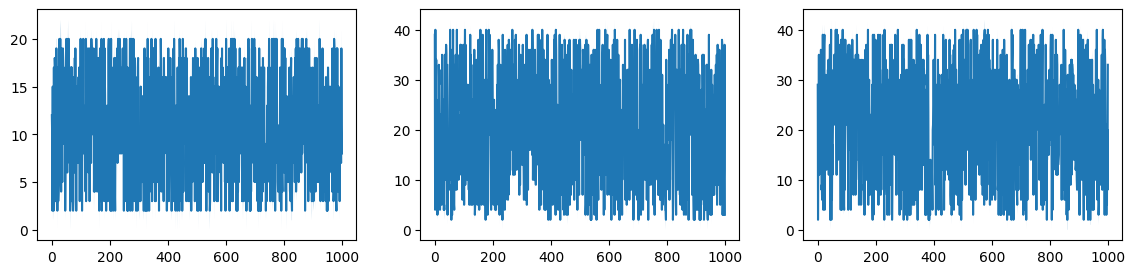

In [5]:
fig, ax = plt.subplots(1,3,figsize=(14,3))
ax.flat[0].plot(np.arange(stop-start),stats_ds_base[0])
ax.flat[0].fill_between(np.arange(stop-start),np.array(stats_ds_base[0])-np.array(stats_ds_var[0]),
                 np.array(stats_ds_base[0])+np.array(stats_ds_var[0]), alpha=0.35)
ax.flat[1].plot(np.arange(stop-start),stats_ds_base[1])
ax.flat[1].fill_between(np.arange(stop-start),np.array(stats_ds_base[1])-np.array(stats_ds_var[1]),
                 np.array(stats_ds_base[1])+np.array(stats_ds_var[1]), alpha=0.35)
ax.flat[2].plot(np.arange(stop-start),stats_ds_base[2])
ax.flat[2].fill_between(np.arange(stop-start),np.array(stats_ds_base[2])-np.array(stats_ds_var[2]),
                 np.array(stats_ds_base[2])+np.array(stats_ds_var[2]), alpha=0.35)

In [6]:
print(np.std(stats_ds_base[0]))
print(np.std(stats_ds_base[1]))
print(np.std(stats_ds_base[2]))
print(np.std(corrupted_fids))

5.575266809758974
11.53486189774286
11.206694383269314
119.00357405102484


In [7]:
with h5py.File(name_dataset_to_be_created, 'w') as h5f:
    # Save inputs, targets, and labels into the HDF5 file
    h5f.create_dataset('corrupted_fids', data=corrupted_fids)
    h5f.create_dataset('ground_truth_fids', data=gt_fids)
    h5f.create_dataset('ppm', data=ppm_of_corrupted_fids)
    h5f.create_dataset('t', data=t_of_corrupted_fids)
    h5f.create_dataset('spectrum', data=target_of_corrupted_fids)

In [8]:
with h5py.File(name_dataset_to_be_created, 'r') as h5f:
    print(h5f.keys())
    print(h5f['corrupted_fids'][()].shape)
    print(h5f['ground_truth_fids'][()].shape)
    print(h5f['ppm'][()].shape)
    print(h5f['spectrum'][()].shape)
    print(h5f['t'][()].shape)

<KeysViewHDF5 ['corrupted_fids', 'ground_truth_fids', 'ppm', 'spectrum', 't']>
(1000, 2048, 2, 40)
(1000, 2048, 2)
(1000, 2048)
(1000, 2048)
(1000, 2048)
